In [137]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


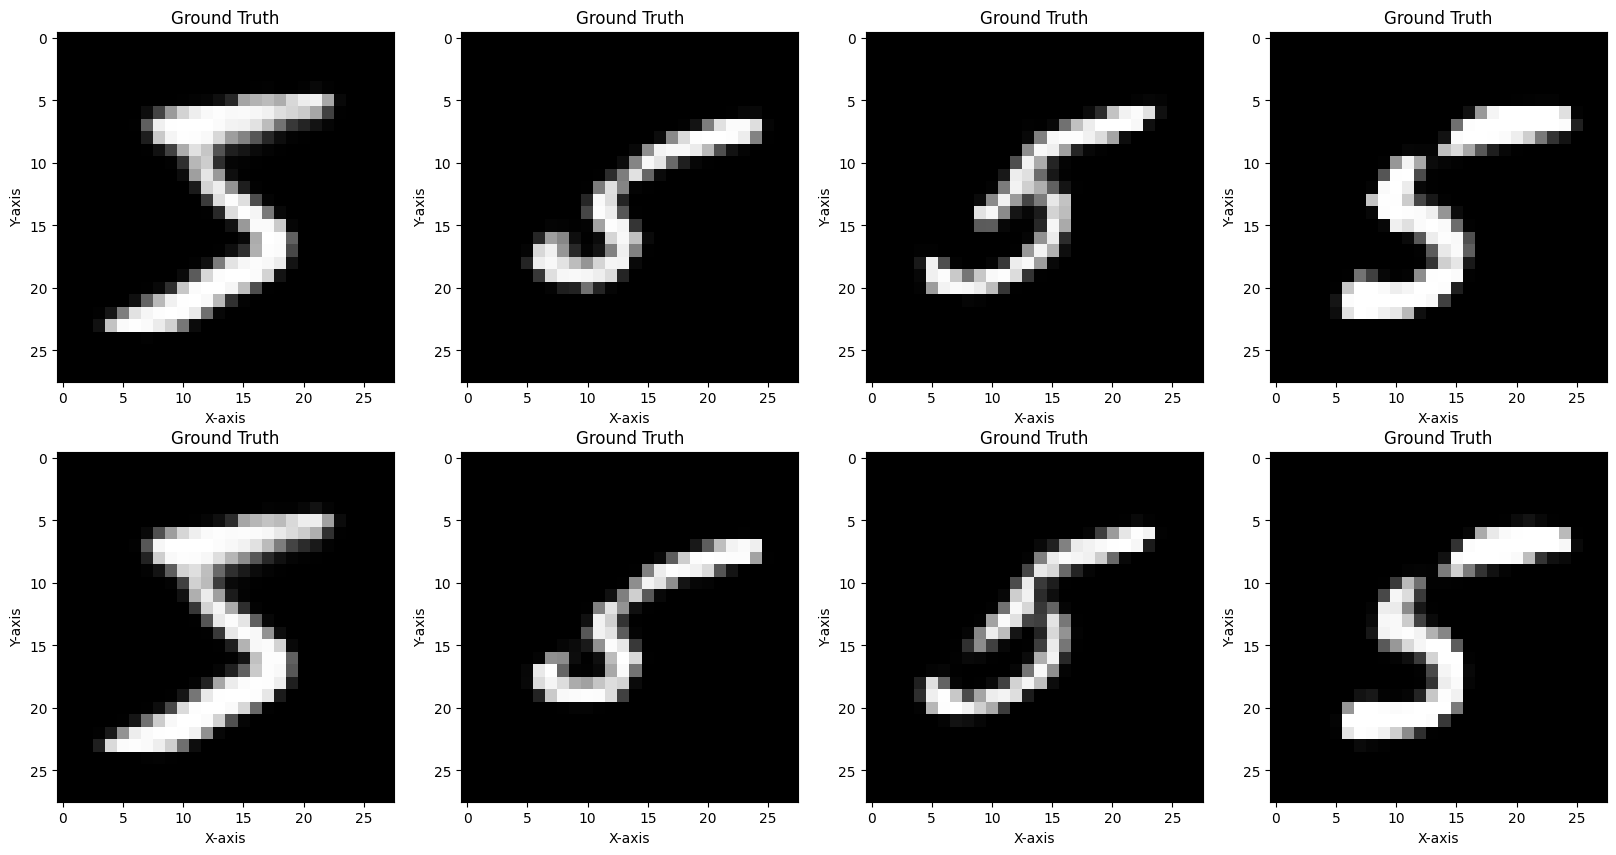

In [138]:
from data.neural_field_datasets import MnistNeFDataset, FlattenTransform, FlattenMinMaxTransform, ModelTransform, QuantizeTransform
import os
import matplotlib.pyplot as plt
from animation.util import reconstruct_image
import wandb
wandb.login()

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root_ours = os.path.join(dir_path, "adl4cv", "datasets", "mnist-nerfs")

idx = range(0, 4)
model_dataset_conditioned = MnistNeFDataset(data_root_ours, type="pretrained",transform=ModelTransform())
model_dataset_unconditioned = MnistNeFDataset(data_root_ours, transform=ModelTransform())
flattened_dataset_conditioned = MnistNeFDataset(data_root_ours, transform=FlattenTransform())
flattened_dataset_unconditioned= MnistNeFDataset(data_root_ours, transform=FlattenTransform())



# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(2, len(idx), figsize=(20, 10))

for i in range(2):
    for j in idx:
        if i == 0:
            image = reconstruct_image(model_dataset_conditioned[j][0])
        else:
            image = reconstruct_image(model_dataset_unconditioned[j][0])
        axes[i][j].imshow(image, cmap='gray', aspect='auto')
        axes[i][j].set_title('Ground Truth')
        axes[i][j].set_xlabel('X-axis')
        axes[i][j].set_ylabel('Y-axis')

#plt.colorbar(axes[i].imshow(image, cmap='gray', aspect='auto'), ax=axes)
plt.show()



In [123]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import generation.train_nerf as training
from munch import DefaultMunch
import torch
import time
import numpy as np



class MNISTNeRFDataset(Dataset):
    def __init__(self, image):
        self.image = image
        self.coords = self._generate_coords()

    def _generate_coords(self):
        h, w = self.image.shape
        coords = np.array([(x, y) for x in range(w) for y in range(h)])
        return coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        x, y = self.coords[idx]
        pixel_value = self.image[y, x]
        # Normalize coordinates to [0, 1]
        x_norm = x / self.image.shape[1]
        y_norm = y / self.image.shape[0]
        return torch.tensor([x_norm, y_norm], dtype=torch.float32), torch.tensor(
            pixel_value, dtype=torch.float32
        )

mnist = datasets.MNIST("mnist-data", train=True, download=True)
image = mnist[35][0]
image = transforms.functional.pil_to_tensor(image).squeeze(0) / 255.0
model = quantized_dataset_conditioned[3][0]

dataset = MNISTNeRFDataset(image)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
#loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
loss_fn = torch.nn.functional.l1_loss

subfoldername = "pretrained"
foldername = (
    f"./datasets/mnist-nerfs/{subfoldername}"
)

cfg = {
        "scheduler": {
            "type": "adaptive",
            "step_size": 30,
            "gamma": 0.1,
            "min_lr": 1e-9,
            "patience": 100,
            "patience_adaptive": 10,
            "factor": 0.95,
            "threshold": 0.00001,
        },
        "strategy": "not_continue",
        "mlp_config": {"move": False},
    }


train_config = {
        "epochs": 500,
        "lr": 1e-4,
        "steps_til_summary": 100,
        "epochs_til_checkpoint": 100,
        "model_dir": "mnist-nerfs-quantized",
        "double_precision": False,
        "clip_grad": False,
        "use_lbfgs": False,
        "loss_schedules": None,
        "filename": "{}/image-{}".format(foldername, i),
    }

# init wandb
wandb.init(
    project="quantization",
    name="image-" + str(i) + "-run-" + time.strftime("%Y-%m-%d-%H-%M-%S"),
    config= train_config | cfg,
)

device = torch.device("cpu") # get_default_device()

save_during_epochs=None
total_loss, output_name = training.train(
        model,
        train_dataloader=dataloader,
        loss_fn=loss_fn,
        **train_config,
        cfg=DefaultMunch.fromDict(cfg),
        wandb=wandb,
        model_config={},
        summary_fn=None,
        save_epoch_interval=save_during_epochs,
        device=device,
        disable_tqdm=False
    )

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▃▆▁▂▇▁▁▄▅▁▃▂▂▁▁▆▇▂▂▇▇▃▁▇▄▃▃▄▁▄▇█▇▁▆▃▅▃█▃
lr,███████▇▇▇▇▇▇▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
epoch,68
epoch_loss,29.03764
loss,0.97199
lr,7e-05


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cpu


  0%|          | 0/392000 [00:00<?, ?it/s]/var/folders/t7/38s2h7694tsbtc8hjlcdxvwm0000gn/T/ipykernel_46563/1304130322.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor([x_norm, y_norm], dtype=torch.float32), torch.tensor(
Epoch 100, Total loss 11.905652, iteration time 0.000346:  20%|██        | 79184/392000 [01:09<04:08, 1260.79it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▂▇▆▄▄▁▅▁▂▅▆▆▂▄▆▅▇▆▆▁▂▄▃▆▂█▅▅▅▅▅▂▁▁▁▂▂▅▄▁
lr,█████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁
total_train_loss,▁
epoch,100
epoch_loss,26.65355
loss,11.90565
lr,6e-05
total_train_loss,11.90565


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/wandb/sdk/wandb_run.py:2265: UserWarning: Run (vlomil79) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
Epoch 100, Total loss 11.905652, iteration time 0.000346:  20%|██        | 79184/392000 [01:13<04:51, 1071.41it/s]


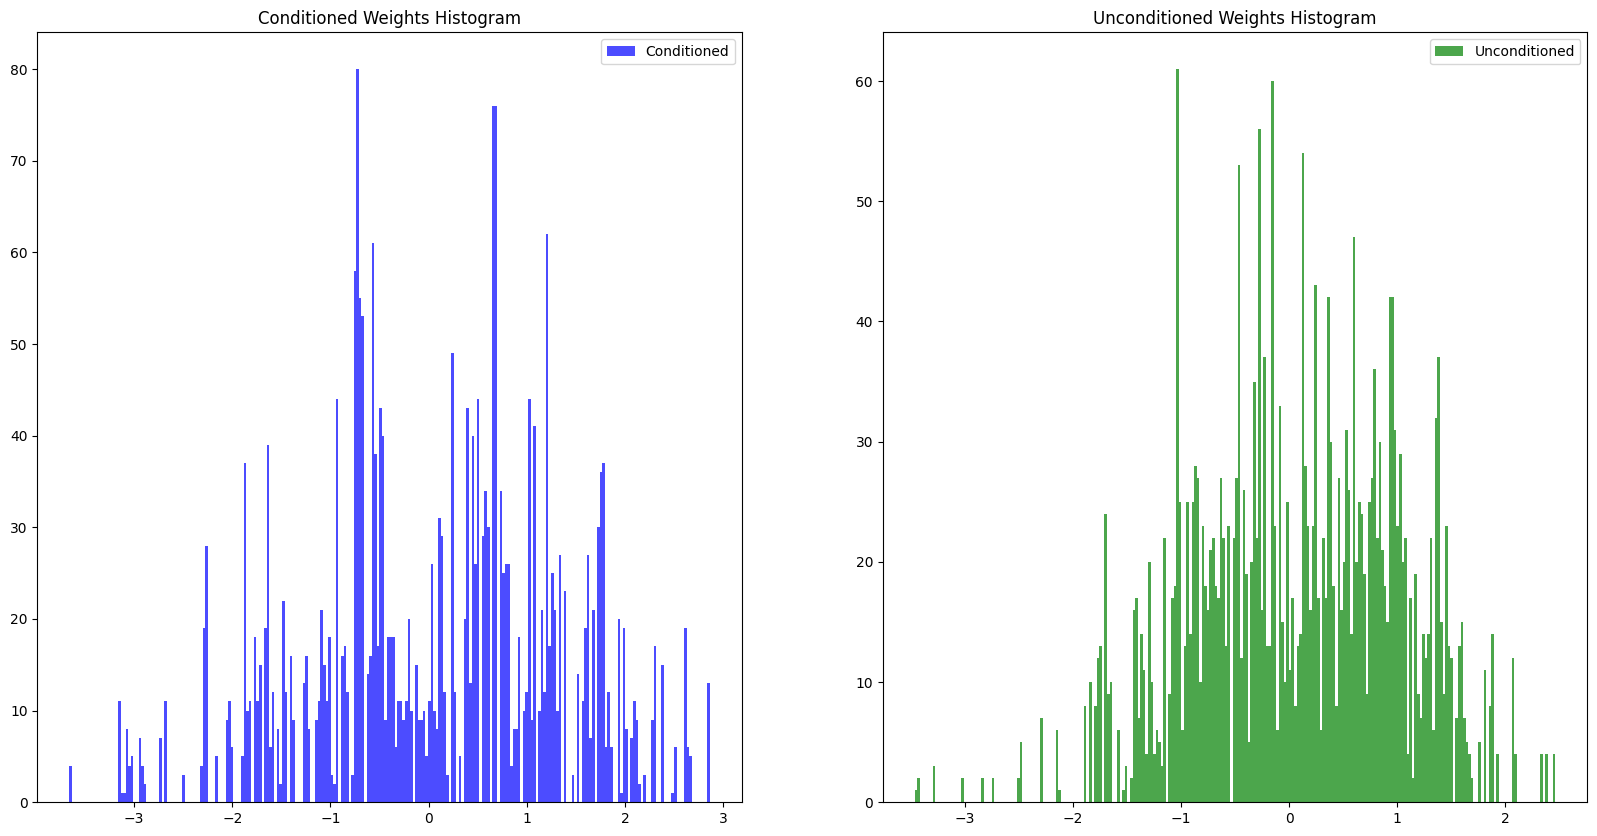

In [290]:
import torch
import matplotlib.pyplot as plt

# Assuming idx, flattened_dataset_conditioned, and flattened_dataset_unconditioned are predefined
flattened_dataset_conditioned = MnistNeFDataset(data_root_ours, type="pretrained", quantized=True, transform=FlattenTransform())
flattened_dataset_unconditioned= MnistNeFDataset(data_root_ours, type="unconditioned", quantized=True, transform=FlattenTransform())

# Assuming idx is predefined and is a list of indices
weights_conditioned = torch.Tensor()
weights_unconditioned = torch.Tensor()

idx = range(0, 5)
for j in idx:
    weights_1d_conditioned = flattened_dataset_conditioned[j][0].numpy()
    weights_conditioned = torch.cat((weights_conditioned, torch.tensor(weights_1d_conditioned)), 0)
    
    weights_1d_unconditioned = flattened_dataset_unconditioned[j][0].numpy()
    weights_unconditioned = torch.cat((weights_unconditioned, torch.tensor(weights_1d_unconditioned)), 0)

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].hist(weights_conditioned.numpy(), bins=250, color='blue', alpha=0.7, label='Conditioned')
axes[0].set_title('Conditioned Weights Histogram')
axes[0].legend()

axes[1].hist(weights_unconditioned.numpy(), bins=250, color='green', alpha=0.7, label='Unconditioned')
axes[1].set_title('Unconditioned Weights Histogram')
axes[1].legend()

plt.show()


torch.Size([2805])

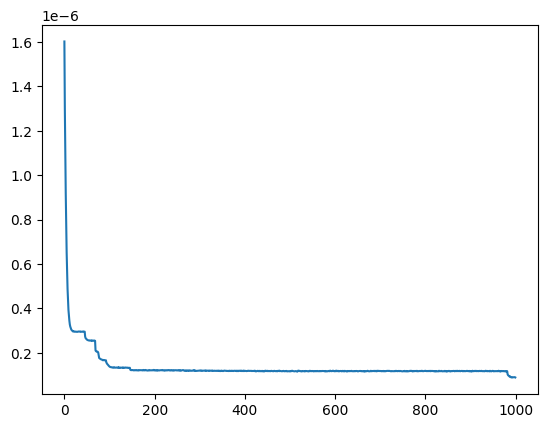

In [298]:
from vector_quantize_pytorch import VectorQuantize

vq = VectorQuantize(
    dim = 1,
    codebook_size = 1024,     # codebook size
    decay = 0.8,             # the exponential moving average decay, lower means the dictionary will change faster
    commitment_weight = 1.,   # the weight on the commitment loss
    kmeans_init=True,
    kmeans_iters=1
)

losses = []

for _ in range(100000):
    weights_quantized, indices, loss = vq(weights_conditioned.unsqueeze(-1))
    losses.append(loss.item())
vq.eval()
vq.zero_grad()

plt.plot(losses)
plt.show()

In [280]:
from vector_quantize_pytorch import VectorQuantize

vq = VectorQuantize(
    dim = 1,
    codebook_size = 1024,     # codebook size
    decay = 0.8,             # the exponential moving average decay, lower means the dictionary will change faster
    commitment_weight = 1.,   # the weight on the commitment loss
)
quantized_dataset_conditioned_no_transform = MnistNeFDataset(data_root_ours, type="pretrained", quantized=True)
#vq.load_state_dict(quantized_dataset_conditioned_no_transform[0][0]["vq_state_dict"])

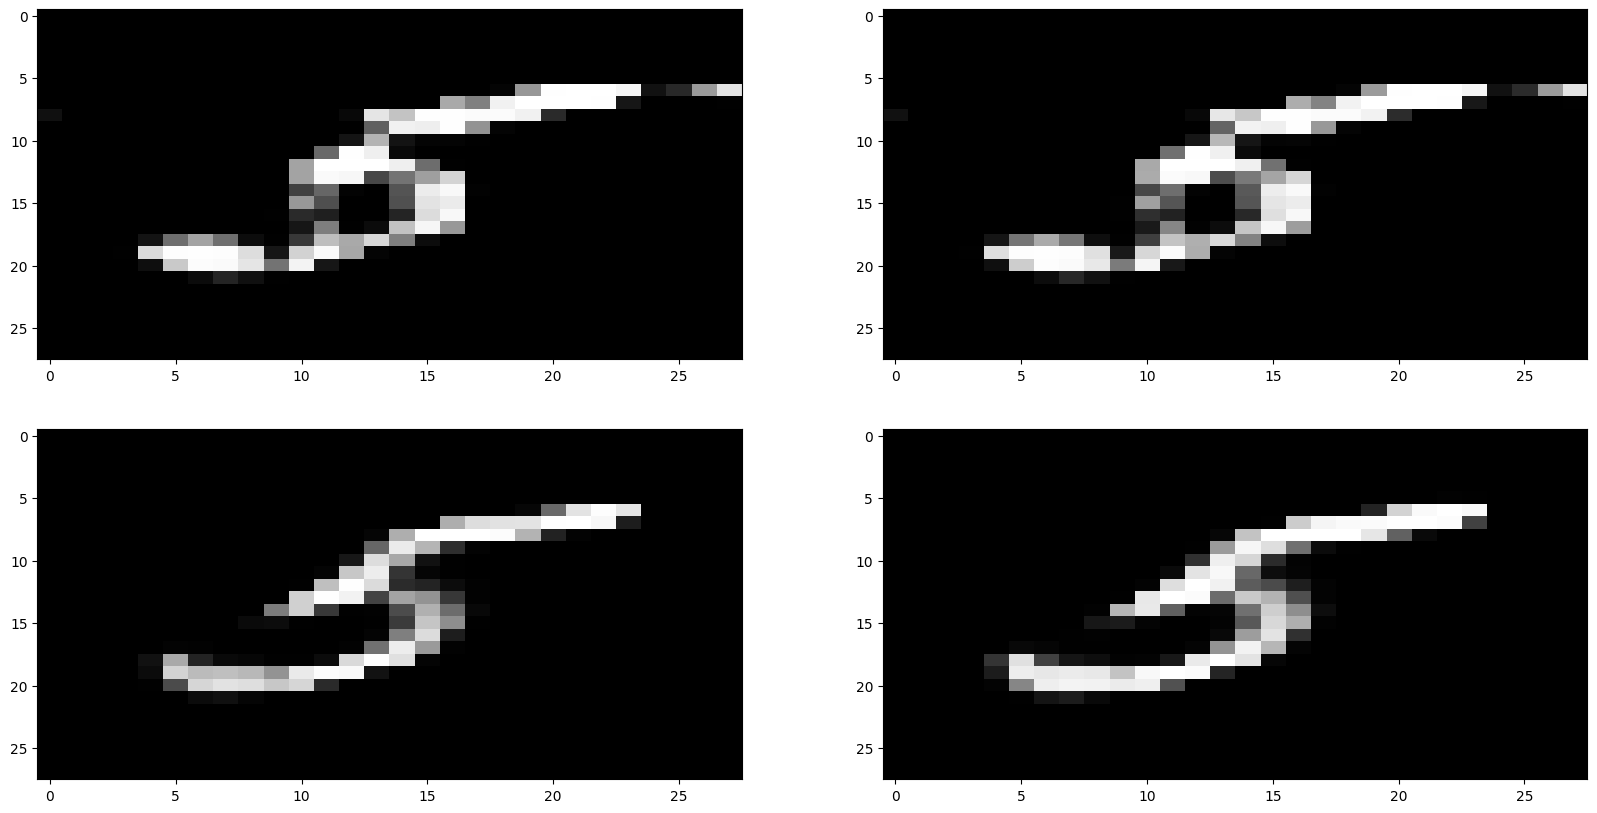

In [291]:
quantized_dataset_conditioned = MnistNeFDataset(data_root_ours, type="pretrained", quantized=True, transform=QuantizeTransform(vq))
no_quantized_dataset_conditioned = MnistNeFDataset(data_root_ours, type="pretrained", quantized=True, transform=ModelTransform())
quantized_dataset_unconditioned = MnistNeFDataset(data_root_ours, quantized=True, transform=QuantizeTransform(vq))
no_quantized_dataset_unconditioned = MnistNeFDataset(data_root_ours, quantized=True, transform=ModelTransform())

idx = 2
model_quantized_conditioned = quantized_dataset_conditioned[idx][0]
model_unquantized_conditioned = no_quantized_dataset_conditioned[idx][0]
model_quantized_unconditioned = quantized_dataset_unconditioned[idx][0]
model_unquantized_unconditioned = no_quantized_dataset_unconditioned[idx][0]

# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
image_quantized_conditioned = reconstruct_image(model_quantized_conditioned)
image_unquantized_conditioned = reconstruct_image(model_unquantized_conditioned)
image_quantized_unconditioned = reconstruct_image(model_quantized_unconditioned)
image_unquantized_unconditioned = reconstruct_image(model_unquantized_unconditioned)
axes[0][0].imshow(image_quantized_conditioned, cmap='gray', aspect='auto')
axes[0][1].imshow(image_unquantized_conditioned, cmap='gray', aspect='auto')
axes[1][0].imshow(image_quantized_unconditioned, cmap='gray', aspect='auto')
axes[1][1].imshow(image_unquantized_unconditioned, cmap='gray', aspect='auto')


plt.show()

False


/var/folders/t7/38s2h7694tsbtc8hjlcdxvwm0000gn/T/ipykernel_46563/527385040.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  weights = torch.range(start=-3, end=3, step=0.01)


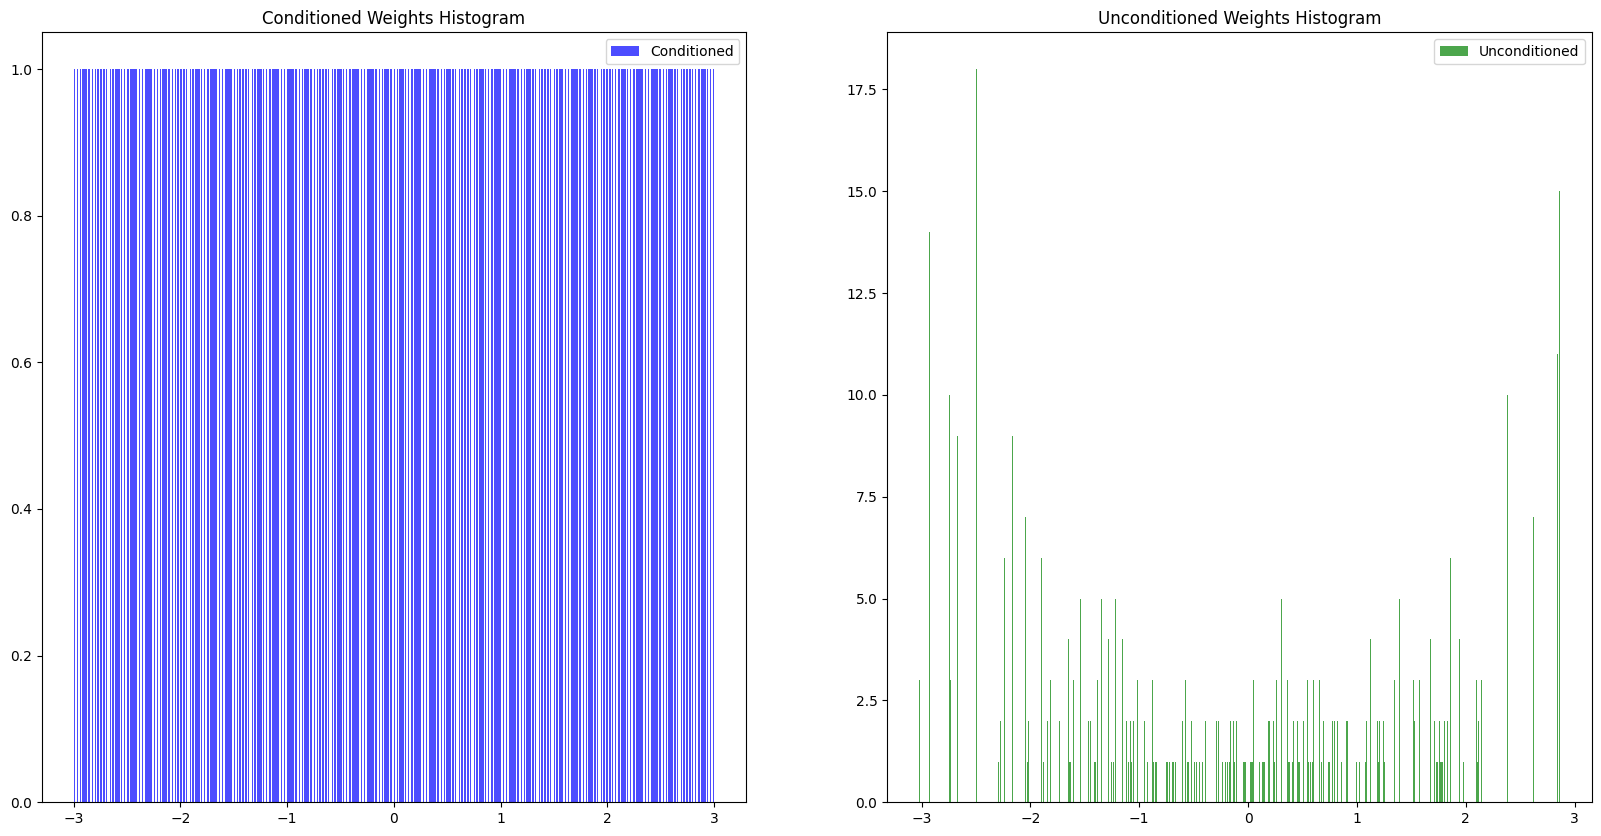

In [289]:
import torch
import matplotlib.pyplot as plt


weights = torch.range(start=-3, end=3, step=0.01)

for _ in range(100):
    weights_quantized = vq(weights.unsqueeze(-1))[0].squeeze(-1)
    

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].hist(weights.numpy(), bins=1024, color='blue', alpha=0.7, label='Conditioned')
axes[0].set_title('Conditioned Weights Histogram')
axes[0].legend()

axes[1].hist(weights_quantized.numpy(), bins=1024, color='green', alpha=0.7, label='Unconditioned')
axes[1].set_title('Unconditioned Weights Histogram')
axes[1].legend()

plt.show()
